In [6]:
import numpy as np
import cv2
import trimesh
import os
from paz.core import Pose6D
import json
from mrcnn import visualize, utils
from paz.core import ops
from mrcnn import visualize, utils
import tensorflow as tf
import paz.processors as pr
import matplotlib.pyplot as plt
from pose_estimation.solver import PnPSolver
from pose_estimation.pose_evaluation import PoseError
from pose_estimation.pose import compute_poses
import pyrender
ROOT_DIR = os.path.abspath("../../../")
MESH_DIR = '/home/incendio/Documents/Thesis/YCBVideo_detector/color_meshes'

In [7]:
class_names = ['background', '002_master_chef_can', '003_cracker_box',
               '004_sugar_box', '005_tomato_soup_can', '006_mustard_bottle',
               '007_tuna_fish_can', '008_pudding_box', '009_gelatin_box',
               '010_potted_meat_can', '011_banana', '019_pitcher_base',
               '021_bleach_cleanser', '024_bowl',
               '025_mug', '035_power_drill',
               '036_wood_block', '037_scissors',
               '040_large_marker', '051_large_clamp',
               '052_extra_large_clamp', '061_foam_brick']

In [ ]:
def evaluation(gt_mask, pred_mask, true_id, name):
    pnp = PnPSolver(gt_mask, true_id, name)
    gt_points3d, image2d = pnp.get_points()
    camera = pnp.compute_camera_matrix()
    _, true_R, true_T, inliers = ops.solve_PNP(gt_points3d, image2d, camera, ops.UPNP)
#     model_point = pnp.get_object_points(image2d)
#     model_point = np.diag(model_point)[..., np.newaxis].T
#     true_R, true_T, _ = pnp.solve_PnP()
    est_pnp = PnPSolver(pred_mask, true_id, name)
    points3d, image2d = est_pnp.get_points()
    _, est_R, est_T, est_inliers = ops.solve_PNP(points3d, image2d, camera, ops.UPNP)
#     est_R, est_T, _ = est_pnp.solve_PnP()
    error = PoseError(gt_points3d, est_R, est_T, true_R, true_T)
    add = error.add()
    adi = error.adi()
    rot_error = error.rotational_error()
    trans_error = error.translational_error()
    return add, adi, rot_error, trans_error

In [36]:
data_dir = os.path.join(ROOT_DIR, 'for_pose_data/train')
mask_dir = data_dir + '/mask/'
with open(data_dir+'/pose_info.json', 'r') as f:
    pose_data = json.load(f)

camera_to_world = np.array([[ 7.0710e-01, -4.0824e-01, 5.7735e-01, 9.9751e-01],
                            [ 6.0047e-17, 8.1649e-01, 5.7735e-01, 9.8064e-01],
                            [-7.0710e-01, -4.0824e-01, 5.7735e-01, 1.0218],
                            [ 0., 0., 0., 1.]])
world_to_camera = np.array([[ 0.70710678, 0., -0.70710678, 0.01674194],
                            [-0.40824829, 0.81649658, -0.40824829, -0.01203142],
                            [ 0.57735027, 0.57735027, 0.57735027, -1.73205081],
                            [ 0., 0., 0., 1.]])
for name in os.listdir(mask_dir):
    pose_id, _ = name.split('.')
    _, class_id = pose_id.split('_')
#     pose = np.array(pose_data[pose_id])
    gt_pose = np.dot(world_to_camera, np.array(pose_data[pose_id]))
    mask = cv2.imread(mask_dir + '/' + name)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    class_name = class_names[int(class_id)]

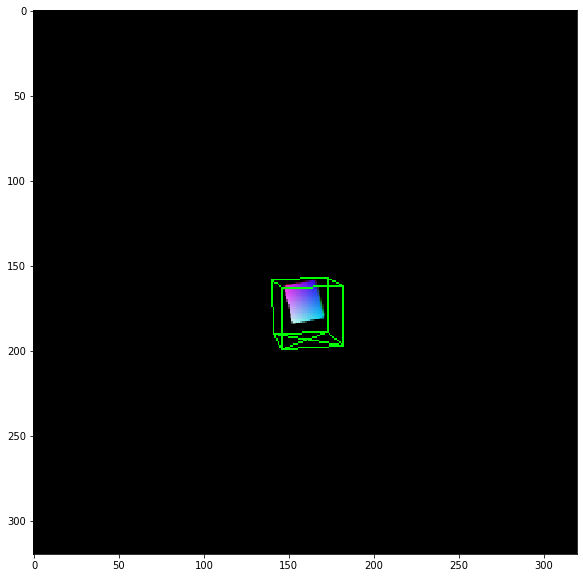

In [37]:
#Ground-truth saved poses
pnp = PnPSolver(mask, int(class_id), class_name, color=(255, 0, 0), dimension=[.08, .08])
camera = pnp.compute_camera_matrix()
rot_test = gt_pose[:3, :3]
pose6D = Pose6D.from_rotation_vector(cv2.Rodrigues(rot_test)[0], gt_pose[:, 3][:3], class_name)
dimensions = {class_name: [.08, .08]}
pose = {'pose6D': pose6D, 'image': mask, 'color': (0, 255, 0)}
draw = pr.DrawBoxes3D(camera, dimensions)
args, projected_points = draw(pose)

fig = plt.figure(figsize=(10, 10))
plt.imshow(args['image'])

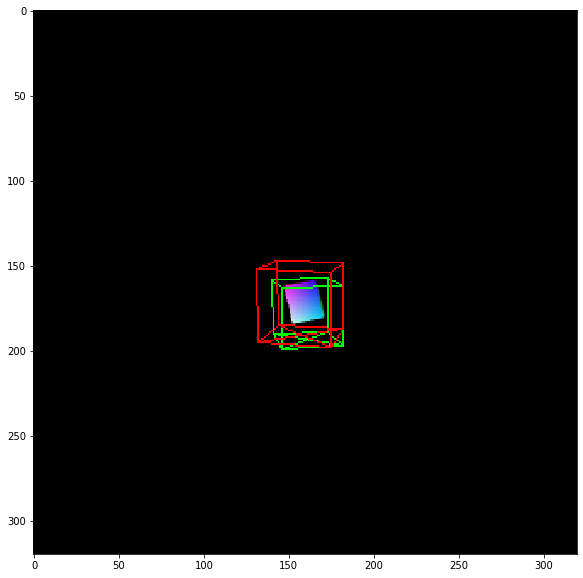

In [38]:
#Poses from PNP_RANSAC algorithm
pnp = PnPSolver(mask, int(class_id), class_name, color=(255, 0, 0), dimension=[.08, .08])
points3d, image2d = pnp.get_points()
_, est_R, est_T, est_inliers = ops.solve_PNP(points3d, image2d, pnp.camera, ops.UPNP)
# camera = pnp.compute_camera_matrix()
# points3d, image2D = pnp.get_points()
# (_, rotation, translation, _) = ops.solve_PNP(points3d, image2D, camera, ops.UPNP)
gt_poses = pnp.solve_PnP()
args, pr_points = pnp.visualize_3D_boxes(mask, gt_poses)
fig = plt.figure(figsize=(10, 10))
plt.imshow(args['image'])

In [39]:
true_R = cv2.Rodrigues(rot_test)[0]
true_T = gt_pose[:, 3][:3]
error = PoseError(points3d, true_R, true_T, est_R, est_T)

(132, 3)
(132, 3)


In [40]:
add = error.add()
adi = error.adi()
rot_error = error.rotational_error()
trans_error = error.translational_error()

In [41]:
print(add, adi, rot_error, trans_error)

2.6947202345472663 2.682733607745677 179.23564351337907 3.8870083300151155


In [7]:
np.dot(world_to_camera, pose)

array([[-0.96737818, -0.17893367,  0.17933822, -0.18965962],
       [-0.25182747,  0.75635119, -0.60375143, -0.09750041],
       [-0.02761122, -0.62921826, -0.77673806, -1.26579355],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [42]:
gt_poses

Pose6D: 
 	 Quaternion: ([0.04262836], [0.33256005], [0.93447071], 0.11979618196138175) 
 	 Translation: ([-0.1915798], [0.0606185], [1.05332307]) 

In [16]:
# print(np.round(pose[:3, :3]))
gt_trans = pose[:, 3][:3]
pred_trans = translation
print('saved pose..', gt_trans)
print('from pnp algorithm', pred_trans)
print(np.linalg.norm(gt_trans - pred_trans))
# r_est, _ = cv2.Rodrigues(rotation)
# print(np.rad2deg(np.arccos((np.trace(cv2.Rodrigues(rotation)[0].dot(pose[:3, :3])) - 1) / 2)))
# print(cv2.Rodrigues(rotation)[0])
# print(translation)

saved pose.. [-0.18965962 -0.09750041 -1.26579355]
from pnp algorithm [[-0.1915798 ]
 [ 0.0606185 ]
 [ 1.05332307]]
3.3552201226335927
179.43742327181025


In [172]:

world_to_camera = np.array([[ 0.70710678, 0., -0.70710678, 0.01674194],
                            [-0.40824829, 0.81649658, -0.40824829, -0.01203142],
                            [ 0.57735027, 0.57735027, 0.57735027, -1.73205081],
                            [ 0., 0., 0., 1.,]])
camera_to_world = np.array([[ 7.0710e-01, -4.0824e-01, 5.7735e-01, 9.9751e-01],
                            [ 6.0047e-17, 8.1649e-01, 5.7735e-01, 9.8064e-01],
                            [-7.0710e-01, -4.0824e-01, 5.7735e-01, 1.0218],
                            [ 0., 0., 0., 1.]])
for name in os.listdir(mask_dir):
    pose_id, _ = name.split('.')
    pose = np.dot(world_to_camera, np.array(pose_data[pose_id]))
#     print(pose)
mesh_path = os.path.join(MESH_DIR, '03_sugar_box.obj')
mesh = trimesh.load(mesh_path)

# before = mesh.visual.vertex_colors[:, :3]
mesh.visual.vertex_colors[:, :3] = [10, 20, 30]
vertex_colors = mesh.visual.vertex_colors[:, :3]
mesh.apply_transform(pose)
# after = mesh.visual.vertex_colors[:, :3]
mesh = pyrender.Mesh.from_trimesh(mesh)
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
s = np.sqrt(2)/2
camera_pose = np.array([[0.0, -s,   s,   0.3],
                        [1.0,  0.0, 0.0, 0.0],
                        [0.0,  s,   s,   0.35],
                        [0.0,  0.0, 0.0, 1.0]])
renderer = pyrender.OffscreenRenderer(viewport_width=320, viewport_height=320)
scene = pyrender.Scene(bg_color=np.zeros(4), ambient_light=np.ones(3))            
scene.add(mesh)
scene.add(camera, pose=camera_pose)
img, _ = renderer.render(scene, flags=pyrender.constants.RenderFlags.FLAT)
# scene = pyrender.Scene()
# scene.add(mesh)
# pyrender.Viewer(scene, use_raymond_lighting=True)

[[10 20 30]
 [10 20 30]
 [10 20 30]
 ...
 [10 20 30]
 [10 20 30]
 [10 20 30]]


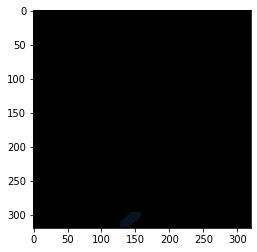

In [173]:
plt.imshow(img)
print(vertex_colors)

In [69]:
data_dir = os.path.join(ROOT_DIR, 'dummy_data/train')
mask_dir = data_dir + '/mask/'
with open(data_dir+'/pose_info.json', 'r') as f:
    pose_data = json.load(f)
masks = []
world_to_camera = np.array([[ 0.70710678, 0., -0.70710678, 0.01674194],
                            [-0.40824829, 0.81649658, -0.40824829, -0.01203142],
                            [ 0.57735027, 0.57735027, 0.57735027, -1.73205081],
                            [ 0., 0., 0., 1.,]])
def get_transformed_mesh(true_id, pose):
    for name in os.listdir(MESH_DIR):
        class_id = name.split('_')[0]
        if int(class_id) == true_id:
            mesh_path = os.path.join(MESH_DIR, name)
            mesh = trimesh.load(mesh_path)
            mesh = mesh.apply_transform(pose)
            vertex_colors = mesh.visual.vertex_colors[:, :3]
    return mesh, vertex_colors

for name in os.listdir(mask_dir):
    pose_id, _ = name.split('.')
    pose = np.dot(world_to_camera, np.array(pose_data[pose_id]))
    class_id = int(name.split('_')[1].split('.')[0])
    mesh, vertex_colors = get_transformed_mesh(class_id, pose)
    mask = cv2.imread(mask_dir + name)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    rows, cols, _ = np.where(mask > 0)
    for index in range(len(rows)):
        x, y = rows[index], cols[index]
        x_index = np.where(mask[x, y, :].all() == vertex_colors.all())
        print(x_index)
#         r_index = np.where(vertex_colors[:, 0] == R)[0]
#         g_index = np.where(vertex_colors[:, 1] == G)[0]
#         b_index = np.where(vertex_colors[:, 2] == B)[0]
#         d = [r_index, g_index, b_index]
#         print(set(d[0]).intersection(*d))
#         rg = np.intersect1d(r_index, g_index)
#         rb = np.intersect1d(r_index, b_index)
#         bg = np.intersect1d(b_index, g_index)
#         if (rg.all() and rb.all() and bg.all()):
            

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(arr

(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array

(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([0]),)
(array([0]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([],

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([0]),)
(array([0]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([],

[[129 122 167 172]
 [194  49 218  75]
 [180 179 211 205]
 [213 203 279 258]
 [149  75 225 147]
 [217 137 295 220]
 [214 110 243 159]]


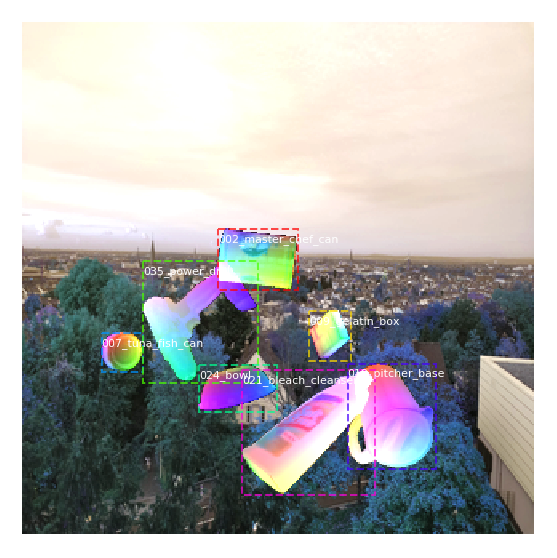

In [6]:
path = './data_verification/data_inspection.json'
with open(path, 'r') as f:
    data = json.load(f)
    
class_names = ['background', '002_master_chef_can', '003_cracker_box',
               '004_sugar_box', '005_tomato_soup_can', '006_mustard_bottle',
               '007_tuna_fish_can', '008_pudding_box', '009_gelatin_box',
               '010_potted_meat_can', '011_banana', '019_pitcher_base',
               '021_bleach_cleanser', '024_bowl',
               '025_mug', '035_power_drill',
               '036_wood_block', '037_scissors',
               '040_large_marker', '051_large_clamp',
               '052_extra_large_clamp', '061_foam_brick']

img = cv2.imread('./data_verification/original.png')
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

class_id = np.array(data['class_id'])
boxes = np.array(data['boxes'])
masks = np.array(data['masks'])
print(boxes)
visualize.display_rgb_instances(image, boxes, masks, class_id, class_names, figsize=(10, 10))